In [1]:
!pip install pydot

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras import Model
import tensorflow_addons as tfa
import tensorflow as tf
from IPython import display

### Dataset

In [23]:
train_ds = tf.keras.utils.image_dataset_from_directory(
#   "/home/tony/TO_BE_REMOVED/celeba_data/imgs/",
  "/home/tony/Desktop/celeba_hq/train",
  seed=123,
  image_size=(256, 256),
  batch_size=2)

Found 18089 files belonging to 2 classes.


In [24]:
K=len(train_ds.class_names)
print(K)

2


In [25]:
for im, l in train_ds.take(1):
    imgs = im
#     print(imgs.shape)
    ls = l.numpy().tolist()
    print(ls)
#     print(l)
#     print(tf.cast(tf.math.round(img[0]), dtype=tf.int32))
#     print(l.numpy())
#     for il in l.numpy():
#         tds = np.array(list(range(K)))
#         tds = tds[tds!=il]
#         print("LABEL: ",il)
#         print("TARGETS: ",tds)
#         print("CHOICE: ", np.random.choice(tds, 1))
    
#     plt.imshow(tf.cast(tf.math.round(img[0]), dtype=tf.int32))

[0, 1]


### Img to Img Generator with style code injection

#### Note:

Implemented with Pre-Act ResBlk

In [88]:
class Generator(Model):
    
    def __init__(self, image_shape_in, image_shape_out, num_channel, kernel_size=3):
        super().__init__()
        
        self.image_shape_in = image_shape_in
        self.image_shape_out = image_shape_out
        self.num_channel = num_channel
        self.kernel_size = kernel_size
        
        # add layer(multiple for plot clarification)
        self.add1 = layers.Add()
        self.add2 = layers.Add()
        self.add3 = layers.Add()
        self.add4 = layers.Add()
        self.add5 = layers.Add()
        self.add6 = layers.Add()
        
        # in conv 1x1
        self.in_conv11 = layers.Conv2D(16, (1, 1),
                                        strides=(1, 1), padding='same',
                                        input_shape=(None, self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        # resblk 1 IN
        self.rb1_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb1_rl1 = layers.ReLU()
        self.rb1_conv2d1 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb1_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb1_rl2 = layers.ReLU()
        self.rb1_conv2d2 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 1
        self.ds1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')

        # resblk 2 IN
        self.rb2_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb2_rl1 = layers.ReLU()
        self.rb2_conv2d1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb2_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb2_rl2 = layers.ReLU()
        self.rb2_conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 2
        self.ds2 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        
        # resblk 3 IN
        self.rb3_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb3_rl1 = layers.ReLU()
        self.rb3_conv2d1 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb3_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb3_rl2 = layers.ReLU()
        self.rb3_conv2d2 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # resblk 4 AdaIN
        self.rb4_in1 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb4_rl1 = layers.ReLU()
        self.rb4_conv2d1 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb4_in2 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb4_rl2 = layers.ReLU()
        self.rb4_conv2d2 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # resblk 5 AdaIN
        self.rb5_in1 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb5_rl1 = layers.ReLU()
        self.rb5_conv2d1 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb5_in2 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb5_rl2 = layers.ReLU()
        self.rb5_conv2d2 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # upsample 1
        self.us1 = layers.Conv2DTranspose(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # resblk 6 AdaIN
        self.rb6_in1 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb6_rl1 = layers.ReLU()
        self.rb6_conv2d1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb6_in2 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb6_rl2 = layers.ReLU()
        self.rb6_conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # upsample 2
        self.us2 = layers.Conv2DTranspose(16, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        
        # out conv 1x1
        self.out_conv11 = layers.Conv2D(3, (1, 1),
                                        strides=(1, 1), padding='same')
            
        
    def call(self, img_in, s_c):
        if img_in.shape[0] == None:
            mu_sc = tf.reshape(tf.reduce_mean(s_c, axis=-1), (1,1,1,1))
            sigma_sc = tf.reshape(tf.math.reduce_std(s_c, axis=-1), (1,1,1,1))
        else:
            mu_sc = tf.reshape(tf.reduce_mean(s_c, axis=-1), (img_in.shape[0],1,1,1))
            sigma_sc = tf.reshape(tf.math.reduce_std(s_c, axis=-1), (img_in.shape[0],1,1,1))        
        # conv 1x1
        x = self.in_conv11(img_in)
        
        # resblk 1
        x_res = self.rb1_conv2d1(self.rb1_rl1(self.rb1_in1(x)))
        x_res = self.rb1_conv2d2(self.rb1_rl2(self.rb1_in2(x_res)))
        x = self.add1([x, x_res])
        
        # resblk 1 downsample
        x = self.ds1(x)
        
        # resblk 2
        x_res = self.rb2_conv2d1(self.rb2_rl1(self.rb2_in1(x)))
        x_res = self.rb2_conv2d2(self.rb2_rl2(self.rb2_in2(x_res)))
        x = self.add2([x, x_res])
        
        # resblk 2 downsample
        x = self.ds2(x)
        
        # resblk 3
        x_res = self.rb3_conv2d1(self.rb3_rl1(self.rb3_in1(x)))
        x_res = self.rb3_conv2d2(self.rb3_rl2(self.rb3_in2(x_res)))
        x = self.add3([x, x_res])
        
        # resblk 4 AdaIN
        x_res = self.rb4_conv2d1(self.rb4_rl1(tf.math.add(tf.math.multiply(self.rb4_in1(x), sigma_sc), mu_sc)))
        x_res = self.rb4_conv2d2(self.rb4_rl2(tf.math.add(tf.math.multiply(self.rb4_in2(x_res), sigma_sc), mu_sc)))
        x = self.add4([x, x_res])

        # resblk 5 AdaIN
        x_res = self.rb5_conv2d1(self.rb5_rl1(tf.math.add(tf.math.multiply(self.rb5_in1(x), sigma_sc), mu_sc)))
        x_res = self.rb5_conv2d2(self.rb5_rl2(tf.math.add(tf.math.multiply(self.rb5_in2(x_res), sigma_sc), mu_sc)))
        x = self.add5([x, x_res])

        # resblk 5 upsample
        x = self.us1(x)

        # resblk 6 AdaIN
        x_res = self.rb6_conv2d1(self.rb6_rl1(tf.math.add(tf.math.multiply(self.rb6_in1(x), sigma_sc), mu_sc)))
        x_res = self.rb6_conv2d2(self.rb6_rl2(tf.math.add(tf.math.multiply(self.rb6_in2(x_res), sigma_sc), mu_sc)))
        x = self.add6([x, x_res])

        # resblk 6 upsample
        x = self.us2(x)
        
        # conv 1x1 out
        x = self.out_conv11(x)
        
        return x
    
    def build_graph(self):
        x = layers.Input(shape=(self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        sc = tf.random.normal((64,))
        return Model(inputs=x, outputs=self.call(x,sc))
        

#### Testing

In [89]:
g_t = Generator((256,256),(256,256),3)

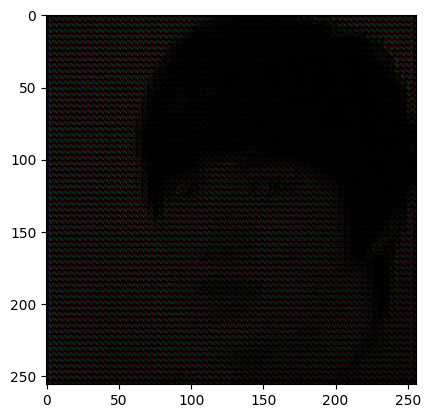

In [90]:
for img, l in train_ds.take(1):
    img = g_t(img, tf.random.normal((2,16)))
    plt.imshow(tf.cast(tf.math.round(img[1]), dtype=tf.int32))

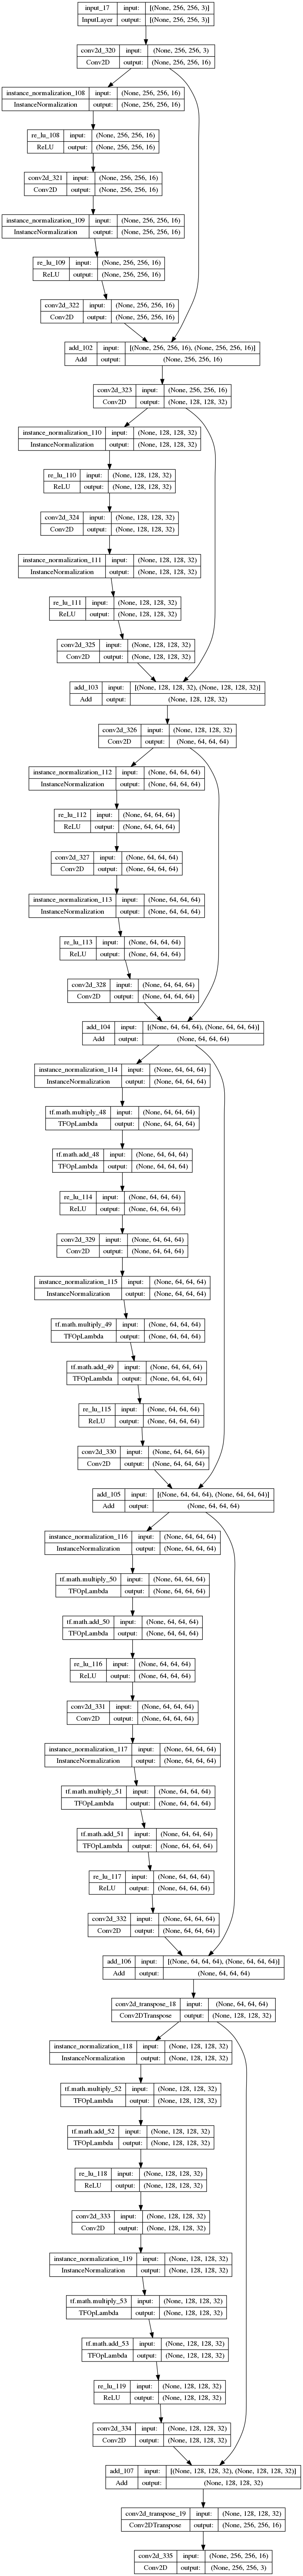

In [92]:
tf.keras.utils.plot_model(g_t.build_graph(), show_shapes=True)

In [93]:
g_t.build_graph().summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_320 (Conv2D)            (None, 256, 256, 16  64          ['input_18[0][0]']               
                                )                                                                 
                                                                                                  
 instance_normalization_108 (In  (None, 256, 256, 16  32         ['conv2d_320[2][0]']             
 stanceNormalization)           )                                                          

 re_lu_114 (ReLU)               (None, 64, 64, 64)   0           ['tf.math.add_54[0][0]']         
                                                                                                  
 conv2d_329 (Conv2D)            (None, 64, 64, 64)   36928       ['re_lu_114[2][0]']              
                                                                                                  
 instance_normalization_115 (In  (None, 64, 64, 64)  0           ['conv2d_329[2][0]']             
 stanceNormalization)                                                                             
                                                                                                  
 tf.math.multiply_55 (TFOpLambd  (None, 64, 64, 64)  0           ['instance_normalization_115[2][0
 a)                                                              ]']                              
                                                                                                  
 tf.math.a

 nspose)                        )                                                                 
                                                                                                  
 conv2d_335 (Conv2D)            (None, 256, 256, 3)  51          ['conv2d_transpose_19[2][0]']    
                                                                                                  
Total params: 309,987
Trainable params: 309,987
Non-trainable params: 0
__________________________________________________________________________________________________


### Mapping Network

In [94]:
class Mapper(Model):

    def __init__(self, noise_dim, sc_dims, num_domains):
        super().__init__()
        self.noise_dim = noise_dim
        self.sl1 = layers.Dense(256, activation="relu")
        self.sl2 = layers.Dense(256, activation="relu")
        self.domain_layers = []
        for i in range(num_domains):
            self.domain_layers.append([layers.Dense(256, activation="relu"), 
                                       layers.Dense(sc_dims)])
            
    def call(self, latent_code):

        x = self.sl1(latent_code)

        x = self.sl2(x)

        xs = []
        for dl in self.domain_layers:
            xs.append(dl[1](dl[0](x)))
        
        return tf.transpose(tf.convert_to_tensor(xs), [1,0,2])

    def build_graph(self):
        x = layers.Input(shape=(self.noise_dim,))
        return Model(inputs=x, outputs=self.call(x))
        

#### Testing

In [95]:
noise = tf.random.normal((2,1))

In [96]:
mapper1 = Mapper(1, 4, 3)

In [97]:
sc_1 = mapper1(noise)
print(sc_1)

tf.Tensor(
[[[ 2.1115923e-03 -2.5227177e-04  5.9003583e-03 -7.7742152e-05]
  [ 3.1824815e-03  2.5670971e-03  3.6765253e-03  4.7968985e-03]
  [-1.6155747e-03 -4.3588774e-03 -2.4743977e-03  4.3670256e-03]]

 [[ 2.4308860e-03 -2.8948137e-04  6.7905542e-03 -8.9306151e-05]
  [ 3.6594663e-03  2.9547075e-03  4.2274334e-03  5.5161058e-03]
  [-1.8592075e-03 -5.0124489e-03 -2.8475588e-03  5.0240490e-03]]], shape=(2, 3, 4), dtype=float32)


In [98]:
ls=[2,1]
s1=[]
i=0
print(sc_1)
for x in tf.unstack(sc_1, axis=0):
    s1.append(tf.unstack(x, axis=0)[ls[i]])
    i=i+1
print(tf.stack(s1, axis=0))

tf.Tensor(
[[[ 2.1115923e-03 -2.5227177e-04  5.9003583e-03 -7.7742152e-05]
  [ 3.1824815e-03  2.5670971e-03  3.6765253e-03  4.7968985e-03]
  [-1.6155747e-03 -4.3588774e-03 -2.4743977e-03  4.3670256e-03]]

 [[ 2.4308860e-03 -2.8948137e-04  6.7905542e-03 -8.9306151e-05]
  [ 3.6594663e-03  2.9547075e-03  4.2274334e-03  5.5161058e-03]
  [-1.8592075e-03 -5.0124489e-03 -2.8475588e-03  5.0240490e-03]]], shape=(2, 3, 4), dtype=float32)
tf.Tensor(
[[-0.00161557 -0.00435888 -0.0024744   0.00436703]
 [ 0.00365947  0.00295471  0.00422743  0.00551611]], shape=(2, 4), dtype=float32)


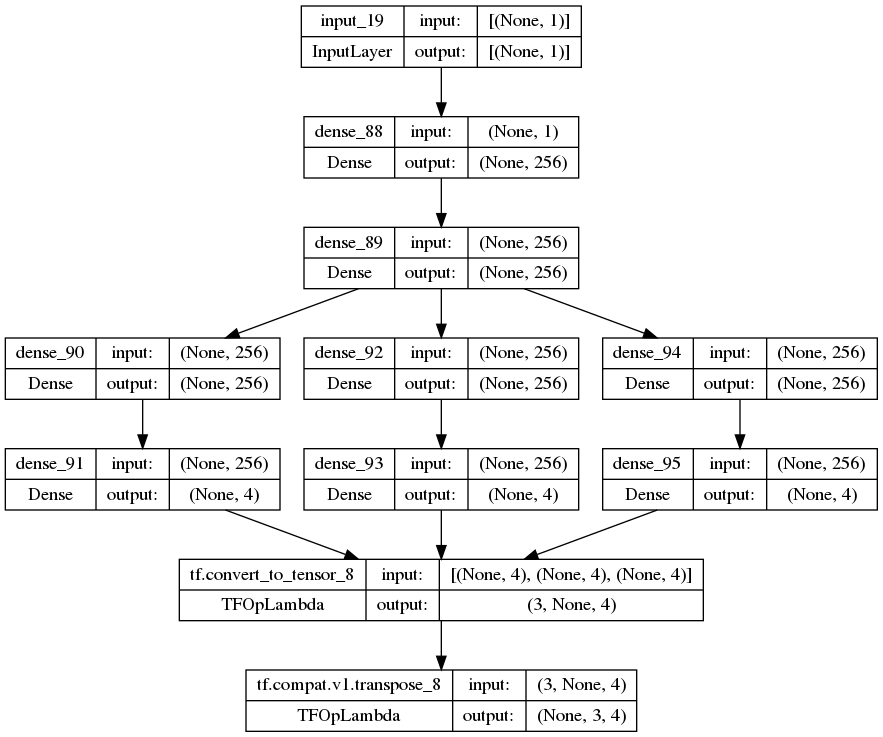

In [99]:
tf.keras.utils.plot_model(mapper1.build_graph(), show_shapes=True)

In [100]:
mapper1.build_graph().summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_88 (Dense)               (None, 256)          512         ['input_20[0][0]']               
                                                                                                  
 dense_89 (Dense)               (None, 256)          65792       ['dense_88[1][0]']               
                                                                                                  
 dense_90 (Dense)               (None, 256)          65792       ['dense_89[1][0]']               
                                                                                           

### Style Encoder

In [104]:
class StyleEncoder(Model):
    
    def __init__(self, image_shape_in, num_channel, sc_dims, num_domains, kernel_size=3):
        super().__init__()
        
        self.image_shape_in = image_shape_in
        self.sc_dims = sc_dims
        self.num_channel = num_channel
        self.kernel_size = kernel_size
        
        # add layer(multiple for plot clarification)
        self.add1 = layers.Add()
        self.add2 = layers.Add()
        self.add3 = layers.Add()

        # in conv 1x1
        self.in_conv11 = layers.Conv2D(8, (1, 1),
                                        strides=(1, 1), padding='same',
                                        input_shape=(None, self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        # resblk 1 
        self.rb1_rl1 = layers.LeakyReLU()
        self.rb1_conv2d1 = layers.Conv2D(8, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb1_rl2 = layers.LeakyReLU()
        self.rb1_conv2d2 = layers.Conv2D(8, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 1
        self.ds1 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # resblk 2
        self.rb2_rl1 = layers.LeakyReLU()
        self.rb2_conv2d1 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb2_rl2 = layers.LeakyReLU()
        self.rb2_conv2d2 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 2
        self.ds2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')

        
        # resblk 3
        self.rb3_rl1 = layers.LeakyReLU()
        self.rb3_conv2d1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb3_rl2 = layers.LeakyReLU()
        self.rb3_conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 3
        self.ds3 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # final downsample
        self.fd_rl1 = layers.LeakyReLU()
        self.fd_ds = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        self.fd_rl2 = layers.LeakyReLU()
        
        # reshape for linear act
        self.rs_out = layers.Reshape((int(self.image_shape_in[0]/16.0)*int(self.image_shape_in[0]/16.0)*64,))
        
        # style code production
        self.sc_layers = []
        for i in range(num_domains):
            self.sc_layers.append(layers.Dense(sc_dims))
            
    def call(self, img_in):
        
        # conv 1x1
        x = self.in_conv11(img_in)
        
        # resblk 1
        x_res = self.rb1_conv2d1(self.rb1_rl1(x))
        x_res = self.rb1_conv2d2(self.rb1_rl2(x_res))
        x = self.add1([x, x_res])
        
        # resblk 1 downsample
        x = self.ds1(x)
        
        # resblk 2
        x_res = self.rb2_conv2d1(self.rb2_rl1(x))
        x_res = self.rb2_conv2d2(self.rb2_rl2(x_res))
        x = self.add2([x, x_res])
        
        # resblk 2 downsample
        x = self.ds2(x)
        
        # resblk 3
        x_res = self.rb3_conv2d1(self.rb3_rl1(x))
        x_res = self.rb3_conv2d2(self.rb3_rl2(x_res))
        x = self.add3([x, x_res])
        
        # resblk 3 downsample
        x = self.ds3(x)
        
        # final downsample
        x = self.fd_rl2(self.fd_ds(self.fd_rl1(x)))
        
        # reshape for linear act
        x = self.rs_out(x)
        
        # style code production
        scs = []
        for sc in self.sc_layers:
            scs.append(sc(x))
            
        return tf.transpose(tf.convert_to_tensor(scs), [1,0,2])
    
    def build_graph(self):
        x = layers.Input(shape=(self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        return Model(inputs=x, outputs=self.call(x))
        

#### Testing

In [105]:
se1 = StyleEncoder((256,256), 3, 4, 3)

In [106]:
for img, l in train_ds.take(1):
    s_ec_1 = se1(img)
    
print(s_ec_1)

tf.Tensor(
[[[ 207.67107   -186.98221    -84.51099   -157.65596  ]
  [  66.469154   -71.7189     -47.74722    -97.479805 ]
  [  13.989069   170.79028     57.23508    -37.406673 ]]

 [[ 162.91591   -108.90323    -25.524206  -128.19632  ]
  [ -22.380333   -82.594185    27.920689   -76.72165  ]
  [ -28.202265   133.29005     43.565353    -5.1574154]]], shape=(2, 3, 4), dtype=float32)


In [107]:
ls=[2,1]
s1=[]
i=0
print(s_ec_1)
for x in tf.unstack(s_ec_1, axis=0):
    s1.append(tf.unstack(x, axis=0)[ls[i]])
    i=i+1
print(tf.stack(s1, axis=0))

tf.Tensor(
[[[ 207.67107   -186.98221    -84.51099   -157.65596  ]
  [  66.469154   -71.7189     -47.74722    -97.479805 ]
  [  13.989069   170.79028     57.23508    -37.406673 ]]

 [[ 162.91591   -108.90323    -25.524206  -128.19632  ]
  [ -22.380333   -82.594185    27.920689   -76.72165  ]
  [ -28.202265   133.29005     43.565353    -5.1574154]]], shape=(2, 3, 4), dtype=float32)
tf.Tensor(
[[ 13.989069 170.79028   57.23508  -37.406673]
 [-22.380333 -82.594185  27.920689 -76.72165 ]], shape=(2, 4), dtype=float32)


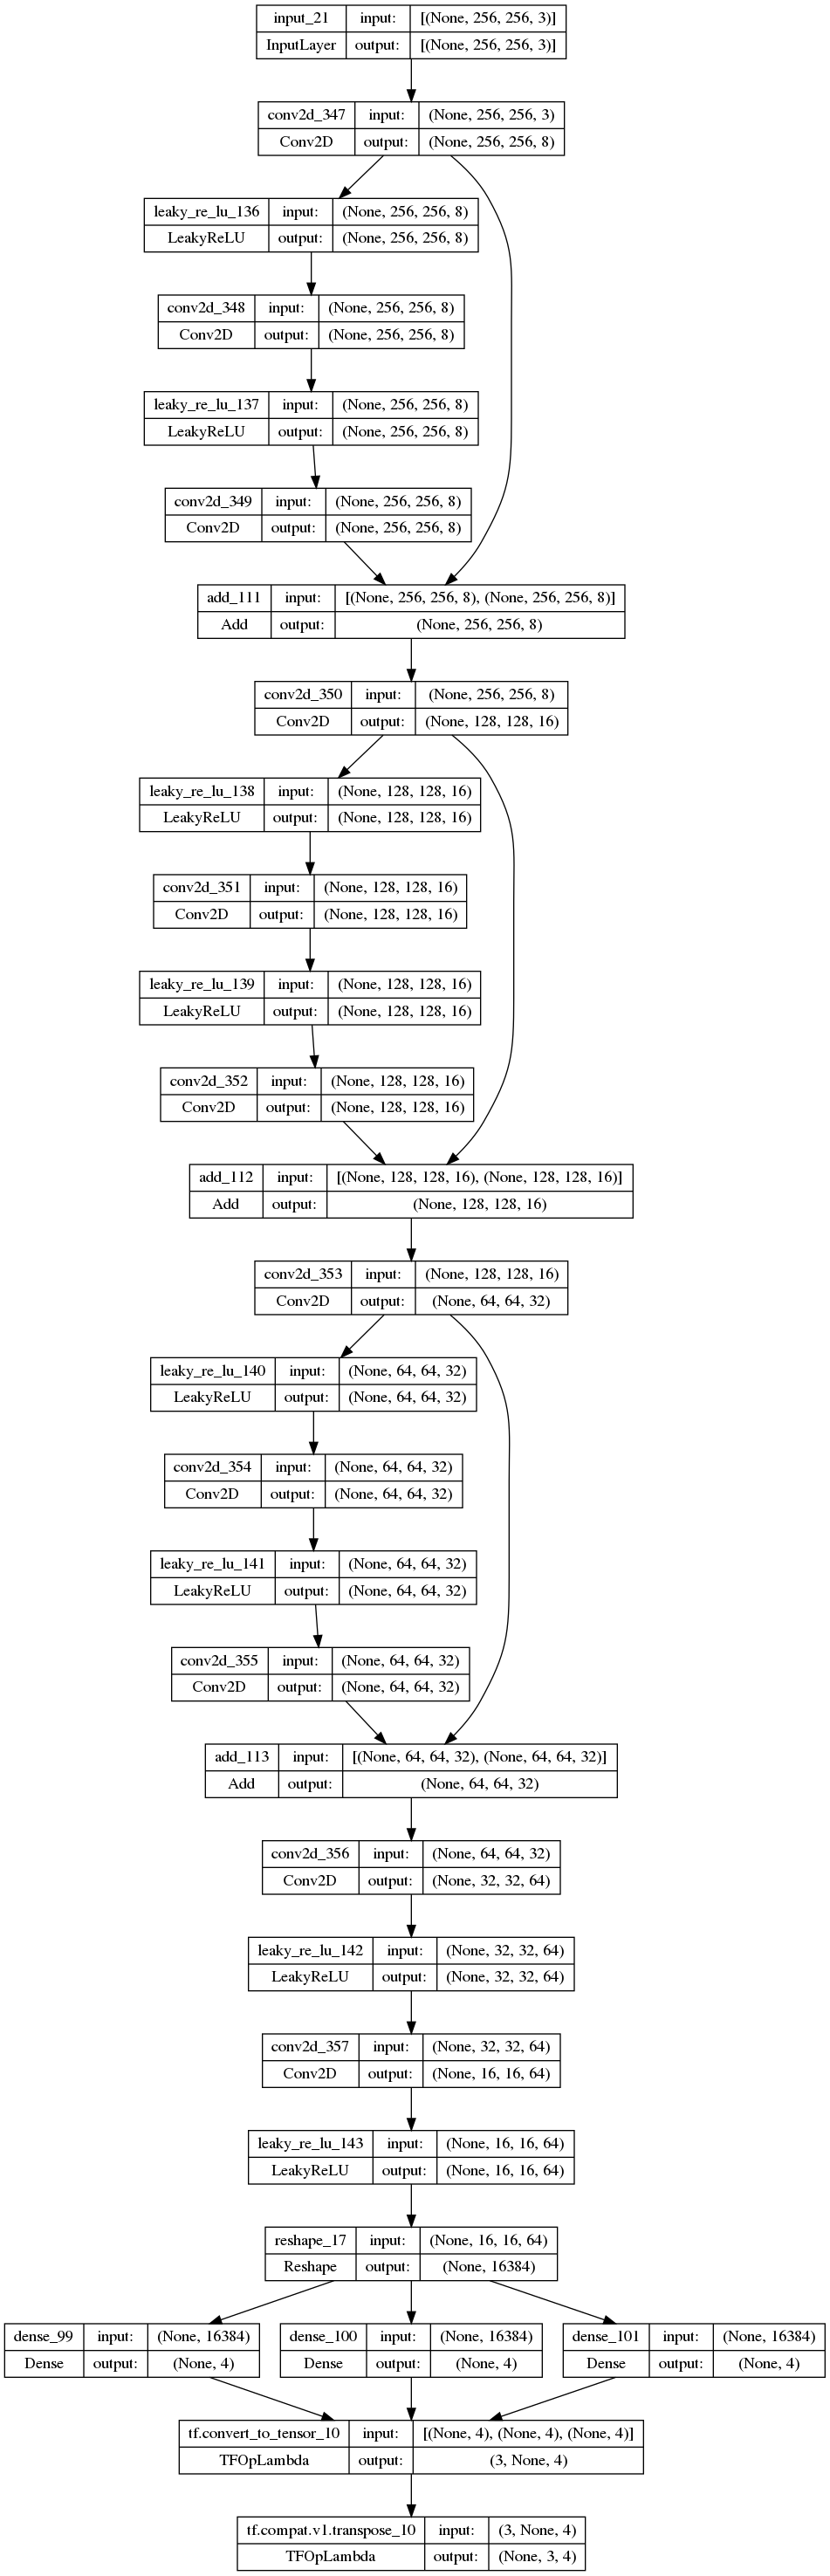

In [108]:
tf.keras.utils.plot_model(se1.build_graph(), show_shapes=True)

In [109]:
se1.build_graph().summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_347 (Conv2D)            (None, 256, 256, 8)  32          ['input_22[0][0]']               
                                                                                                  
 leaky_re_lu_136 (LeakyReLU)    (None, 256, 256, 8)  0           ['conv2d_347[1][0]']             
                                                                                                  
 conv2d_348 (Conv2D)            (None, 256, 256, 8)  584         ['leaky_re_lu_136[1][0]'] 

### Multi-domain Discriminator

In [116]:
class MDDiscriminator(Model):
    
    def __init__(self, image_shape_in, num_channel, num_domains, num_out_filter=16, kernel_size=3):
        super().__init__()
        
        self.image_shape_in = image_shape_in
        self.num_channel = num_channel
        self.kernel_size = kernel_size
        
        # add layer(multiple for plot clarification)
        self.add1 = layers.Add()
        self.add2 = layers.Add()
        self.add3 = layers.Add()

        # in conv 1x1
        self.in_conv11 = layers.Conv2D(8, (1, 1),
                                        strides=(1, 1), padding='same',
                                        input_shape=(None, self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        # resblk 1 
        self.rb1_rl1 = layers.LeakyReLU()
        self.rb1_conv2d1 = layers.Conv2D(8, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb1_rl2 = layers.LeakyReLU()
        self.rb1_conv2d2 = layers.Conv2D(8, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 1
        self.ds1 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # resblk 2
        self.rb2_rl1 = layers.LeakyReLU()
        self.rb2_conv2d1 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb2_rl2 = layers.LeakyReLU()
        self.rb2_conv2d2 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 2
        self.ds2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')

        
        # resblk 3
        self.rb3_rl1 = layers.LeakyReLU()
        self.rb3_conv2d1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb3_rl2 = layers.LeakyReLU()
        self.rb3_conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 3
        self.ds3 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # final downsample
        self.fd_rl1 = layers.LeakyReLU()
        self.fd_ds = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        self.fd_rl2 = layers.LeakyReLU()
        
        # reshape for linear act
        self.rs_out = layers.Reshape((int(self.image_shape_in[0]/16.0)*int(self.image_shape_in[0]/16.0)*64,))
        
        # style code production
        self.rf_layers = []
        for i in range(num_domains):
            self.rf_layers.append(layers.Dense(num_out_filter))
            
    def call(self, img_in):
        
        # conv 1x1
        x = self.in_conv11(img_in)
        
        # resblk 1
        x_res = self.rb1_conv2d1(self.rb1_rl1(x))
        x_res = self.rb1_conv2d2(self.rb1_rl2(x_res))
        x = self.add1([x, x_res])
        
        # resblk 1 downsample
        x = self.ds1(x)
        
        # resblk 2
        x_res = self.rb2_conv2d1(self.rb2_rl1(x))
        x_res = self.rb2_conv2d2(self.rb2_rl2(x_res))
        x = self.add2([x, x_res])
        
        # resblk 2 downsample
        x = self.ds2(x)
        
        # resblk 3
        x_res = self.rb3_conv2d1(self.rb3_rl1(x))
        x_res = self.rb3_conv2d2(self.rb3_rl2(x_res))
        x = self.add3([x, x_res])
        
        # resblk 3 downsample
        x = self.ds3(x)
        
        # final downsample
        x = self.fd_rl2(self.fd_ds(self.fd_rl1(x)))
        
        # reshape for linear act
        x = self.rs_out(x)
        
        # style code production
        rfs = []
        for rf in self.rf_layers:
            rfs.append(rf(x))
        
        return tf.transpose(tf.convert_to_tensor(rfs), [1,0,2])
    
    def build_graph(self):
        x = layers.Input(shape=(self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        return Model(inputs=x, outputs=self.call(x))
        

#### Testing

In [117]:
mdd1 = MDDiscriminator((256,256), 3, 3)

In [118]:
for img, l in train_ds.take(1):
    ds = mdd1(img)
print(ds)

tf.Tensor(
[[[-1.8491766e+01 -6.7461678e+01 -4.3522959e+00  8.2350702e+00
    4.1460445e+01 -4.0471859e+01  3.7902780e+00  4.9268906e+01
    2.8503515e+01 -1.5465404e+01  5.1376797e+01  2.9960320e+01
    2.1487371e+01  9.0084133e+00 -3.0920046e+01 -8.4222615e-01]
  [ 3.7886955e+01 -1.6002005e+01 -5.1770864e+00 -4.4750515e+01
    2.8702614e+01  9.8770561e+00  2.5997784e+01  2.8557334e+00
    1.0587855e+01 -5.2928326e+01 -2.0553564e+01  2.4055723e+01
   -7.5655838e+01  7.9974068e+01 -9.4243439e+01 -5.7446217e+01]
  [ 1.7252462e+01 -3.1517977e+01 -7.2904808e+01 -1.7037178e+01
    1.6331934e+01  8.4341526e-02 -8.2308683e+00  3.8589054e+01
   -5.5907483e+00 -6.9816696e+01 -1.5355032e+01 -3.8779282e+01
    5.2006550e+00  5.2731251e+01  4.1157871e+01  4.4103837e+00]]

 [[-4.4742455e+01 -1.5278881e+01 -8.0764427e+00 -4.0227861e+00
   -7.3305397e+00 -2.1877991e+01  5.6200247e+00  3.7300560e+01
    3.3851574e+01 -2.1051334e+01  3.6314316e+01  1.4515568e+01
    2.1343542e+01 -1.2637032e+01 -3.159

In [119]:
ls=[2,1]
s1=[]
i=0
print(ds)
for x in tf.unstack(ds, axis=0):
    s1.append(tf.unstack(x, axis=0)[ls[i]])
    i=i+1
print(tf.stack(s1, axis=0))

tf.Tensor(
[[[-1.8491766e+01 -6.7461678e+01 -4.3522959e+00  8.2350702e+00
    4.1460445e+01 -4.0471859e+01  3.7902780e+00  4.9268906e+01
    2.8503515e+01 -1.5465404e+01  5.1376797e+01  2.9960320e+01
    2.1487371e+01  9.0084133e+00 -3.0920046e+01 -8.4222615e-01]
  [ 3.7886955e+01 -1.6002005e+01 -5.1770864e+00 -4.4750515e+01
    2.8702614e+01  9.8770561e+00  2.5997784e+01  2.8557334e+00
    1.0587855e+01 -5.2928326e+01 -2.0553564e+01  2.4055723e+01
   -7.5655838e+01  7.9974068e+01 -9.4243439e+01 -5.7446217e+01]
  [ 1.7252462e+01 -3.1517977e+01 -7.2904808e+01 -1.7037178e+01
    1.6331934e+01  8.4341526e-02 -8.2308683e+00  3.8589054e+01
   -5.5907483e+00 -6.9816696e+01 -1.5355032e+01 -3.8779282e+01
    5.2006550e+00  5.2731251e+01  4.1157871e+01  4.4103837e+00]]

 [[-4.4742455e+01 -1.5278881e+01 -8.0764427e+00 -4.0227861e+00
   -7.3305397e+00 -2.1877991e+01  5.6200247e+00  3.7300560e+01
    3.3851574e+01 -2.1051334e+01  3.6314316e+01  1.4515568e+01
    2.1343542e+01 -1.2637032e+01 -3.159

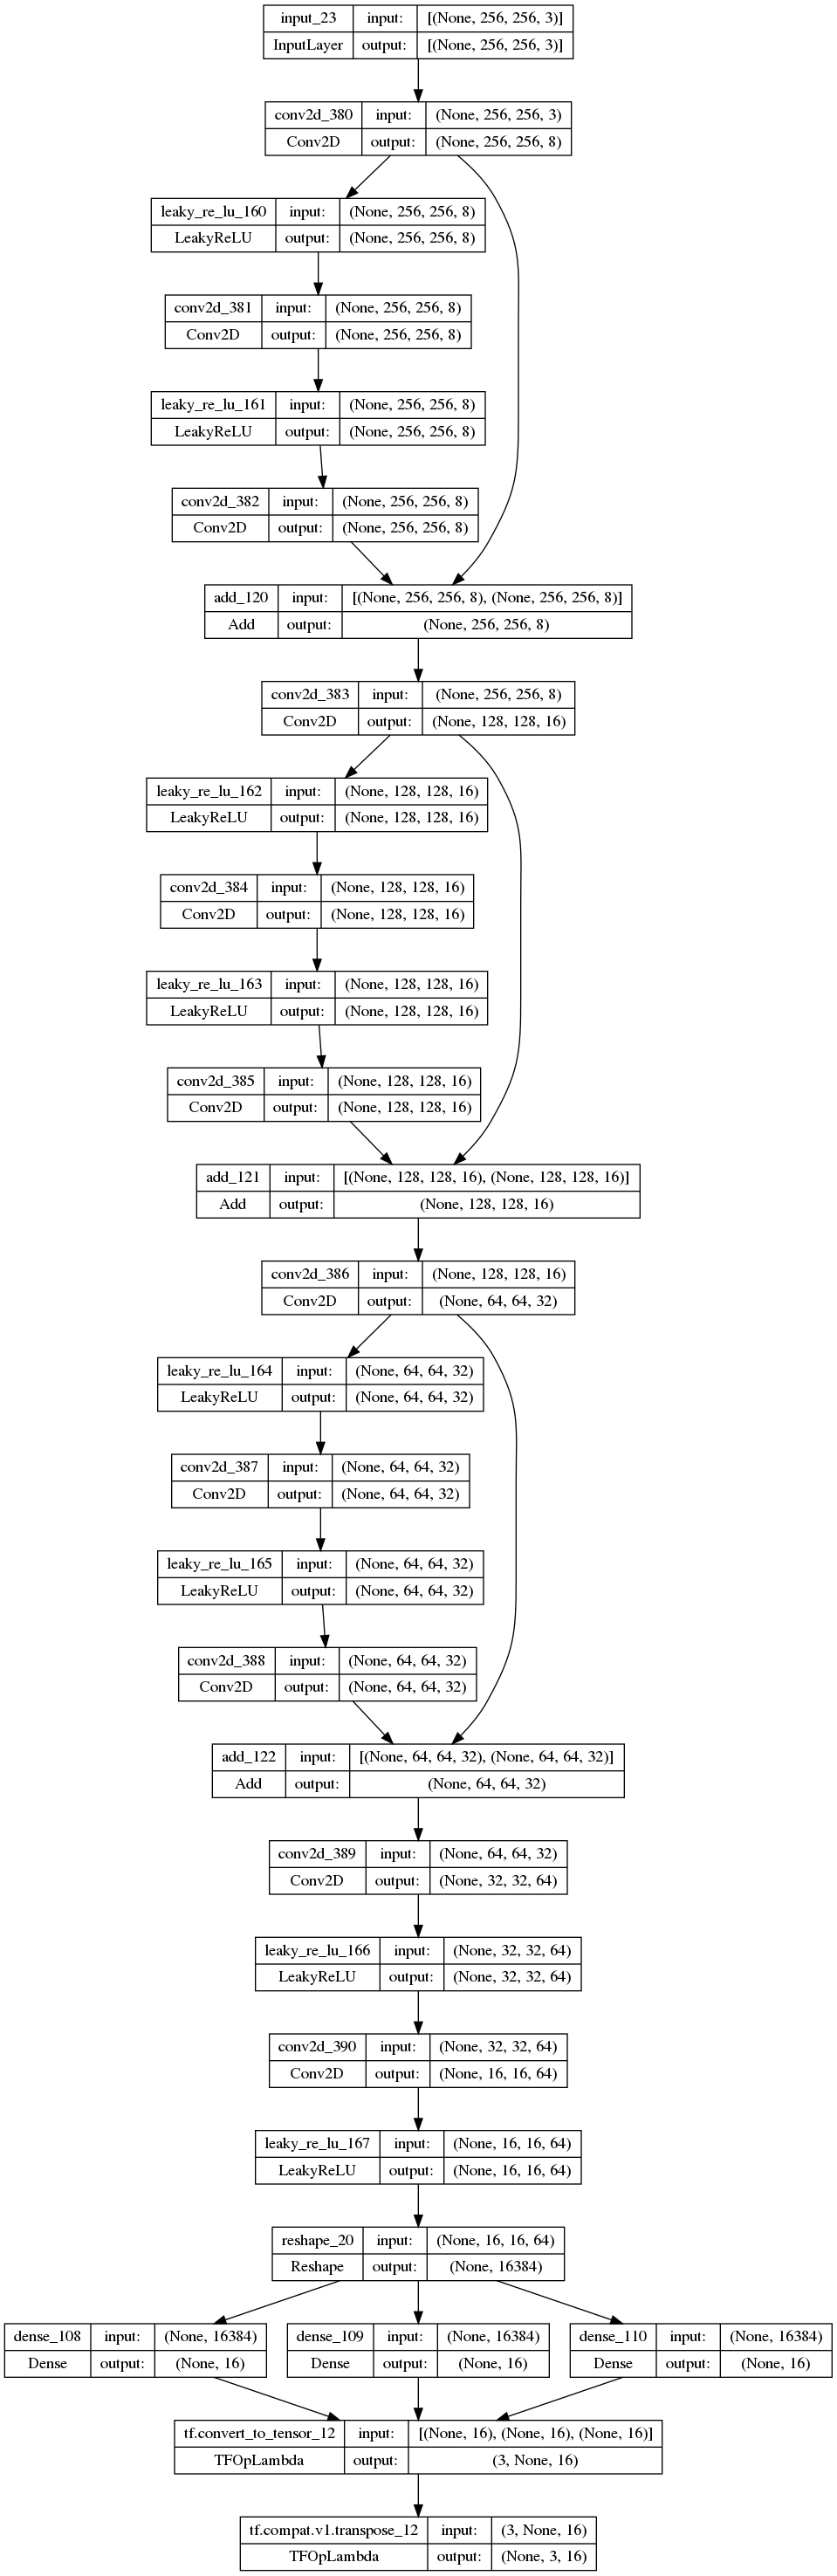

In [120]:
tf.keras.utils.plot_model(mdd1.build_graph(), show_shapes=True)

In [121]:
mdd1.build_graph().summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_380 (Conv2D)            (None, 256, 256, 8)  32          ['input_24[0][0]']               
                                                                                                  
 leaky_re_lu_160 (LeakyReLU)    (None, 256, 256, 8)  0           ['conv2d_380[1][0]']             
                                                                                                  
 conv2d_381 (Conv2D)            (None, 256, 256, 8)  584         ['leaky_re_lu_160[1][0]'] 

### StarGAN-v2

In [136]:
EPSILON = 1e-16

class StarGAN2:
    
    def __init__(self, dataset_path, image_shape, num_channel, noise_latent_dim, sc_dim, num_out_filter=16, disc_update_multi=5, 
                 batch_size=128, lr=3e-4, gp_lam=10.0, sty_lam=1.0, ds_lam=1.0, cyc_lam=1.0):
        assert len(image_shape) == 2
        assert image_shape[0]%16 == 0
        assert image_shape[1]%16 == 0
        
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.noise_latent_dim = noise_latent_dim
        self.sc_dim = sc_dim
        self.batch_size, self.gp_lam, self.sty_lam, self.ds_lam, self.cyc_lam = batch_size, gp_lam, sty_lam, ds_lam, cyc_lam
        self.disc_update_multi = disc_update_multi
        self.num_domains = 1
        if not dataset_path==None:
            self.dataset = tf.keras.utils.image_dataset_from_directory(
                                  dataset_path,
                                  seed=123,
                                  image_size=self.image_shape,
                                  batch_size=self.batch_size)
            self.num_domains = len(self.dataset.class_names)
        else:
            print("WARNING: Dataset not loaded, Model in Generator mode")
        # NOTE: Dataset must be processed differently for different source and applications
        
        self.g = Generator(self.image_shape, self.image_shape, self.num_channel)
        self.f = Mapper(self.noise_latent_dim, self.sc_dim, self.num_domains)
        self.e = StyleEncoder(self.image_shape, self.num_channel, self.sc_dim, self.num_domains)
        self.d = MDDiscriminator(self.image_shape, self.num_channel, self.num_domains, num_out_filter=num_out_filter)
        
        self.g_opt = tf.keras.optimizers.Adam(lr)
        self.f_opt = tf.keras.optimizers.Adam(lr)
        self.e_opt = tf.keras.optimizers.Adam(lr)
        self.d_opt = tf.keras.optimizers.Adam(lr)

    def adv_loss(self, dty_xt, dty_gs1, dty_gs2, dy_xy, dy_styrecg1):
        
        l2nrgs1 = tf.math.sqrt(tf.reduce_sum(tf.math.add(dty_xt, -dty_gs1)**2, axis = 1)+EPSILON)
        l2nrgs2 = tf.math.sqrt(tf.reduce_sum(tf.math.add(dty_xt, -dty_gs2)**2, axis = 1)+EPSILON)
        l2ngs12 = tf.math.sqrt(tf.reduce_sum(tf.math.add(dty_gs1, -dty_gs2)**2, axis = 1)+EPSILON)
        l2nrstyrec = tf.math.sqrt(tf.reduce_sum(tf.math.add(dy_xy, -dy_styrecg1)**2, axis = 1)+EPSILON)

        # adv_loss
        L_adv = l2nrgs1 + l2nrstyrec + l2nrgs2 - l2ngs12

        return tf.reduce_mean(L_adv)
    
    def gp_loss(self, xty_it, dty_xt, dty_gs2, tls):
        
        with tf.GradientTape() as t_gp:
            t_gp.watch(xty_it)
            dty_xit = self.take_domain_output(self.d(xty_it), tls)
            fty_xit = tf.math.add(tf.math.sqrt(tf.reduce_sum(tf.math.add(dty_xit, -dty_gs2)**2, axis = 1)+EPSILON),
                   -tf.math.sqrt(tf.reduce_sum(tf.math.add(dty_xit, -dty_xt)**2, axis = 1)+EPSILON))
            
        gp_grad = t_gp.gradient(fty_xit, xty_it)
        l2n_gp = tf.math.sqrt(tf.reduce_sum(gp_grad**2, axis = [1,2,3])+EPSILON)
        L_gp = (l2n_gp-1.0)**2
        return tf.reduce_mean(L_gp)
        
    def ds_loss(self, g_s1, g_s2):
        
        l2ngs12 = tf.math.sqrt(tf.reduce_sum(tf.math.add(g_s1, -g_s2)**2, axis = [1,2,3])+EPSILON)

        return tf.reduce_mean(l2ngs12)
        
    def cyc_loss(self, imgs, styrec_g1, styrec_g2):
        
        l2nxygs1 = tf.math.sqrt(tf.reduce_sum(tf.math.add(imgs, -styrec_g1)**2, axis = [1,2,3])+EPSILON)
        l2nxygs2 = tf.math.sqrt(tf.reduce_sum(tf.math.add(imgs, -styrec_g2)**2, axis = [1,2,3])+EPSILON)
        
        L_cyc = l2nxygs1+l2nxygs2
        
        return tf.reduce_mean(L_cyc)
        
    def sty_loss(self, s_hat1, s_hat2, ety_gs1, ety_gs2):
        
        l2ns1 = tf.math.sqrt(tf.reduce_sum(tf.math.add(s_hat1, -ety_gs1)**2, axis = 1)+EPSILON)
        l2ns2 = tf.math.sqrt(tf.reduce_sum(tf.math.add(s_hat2, -ety_gs2)**2, axis = 1)+EPSILON)

        L_sty = l2ns1+l2ns2
        
        return tf.reduce_mean(L_sty)
        
    def take_domain_output(self, out, ls):
        d_out = []
        i=0
        for x in tf.unstack(out, axis=0):
            d_out.append(tf.unstack(x, axis=0)[ls[i]])
            i=i+1
        return tf.stack(d_out, axis=0)
    
#     @tf.function
    def update(self, imgs, ls, timgs, tls, update_gen=True):
        
        noise_input1 = tf.random.normal((imgs.shape[0], self.noise_latent_dim))
        noise_input2 = tf.random.normal((imgs.shape[0], self.noise_latent_dim))
        
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape, tf.GradientTape() as f_tape, tf.GradientTape() as e_tape:
            s_hat1 = self.take_domain_output(self.f(noise_input1), tls)
            s_hat2 = self.take_domain_output(self.f(noise_input2), tls)
            
            g_s1 = self.g(imgs, s_hat1)
            g_s2 = self.g(imgs, s_hat2)
            
            dy_xy = self.take_domain_output(self.d(imgs), ls)
            dty_xt = self.take_domain_output(self.d(timgs), tls)

            dty_gs1 = self.take_domain_output(self.d(g_s1), tls)
            dty_gs2 = self.take_domain_output(self.d(g_s2), tls)

            epsi = tf.random.uniform([timgs.shape[0], 1, 1, 1], 0.0, 1.0)
            xty_it = tf.math.add(epsi*timgs, (1.0-epsi)*g_s1)
#             dty_xit = self.take_domain_output(self.d(xty_it), tls)
            
            ey_xy = self.take_domain_output(self.e(imgs), ls)
            styrec_g1 = self.g(g_s1, ey_xy)
            styrec_g2 = self.g(g_s2, ey_xy)
            dy_styrecg1 = self.take_domain_output(self.d(styrec_g1), ls)
            
            ety_gs1 = self.take_domain_output(self.e(g_s1), tls)
            ety_gs2 = self.take_domain_output(self.e(g_s2), tls)
            
            adv_loss = self.adv_loss(dty_xt, dty_gs1, dty_gs2, dy_xy, dy_styrecg1)
            gp_loss = self.gp_loss(xty_it, dty_xt, dty_gs2, tls)
            ds_loss = self.ds_loss(g_s1, g_s2)
            cyc_loss = self.cyc_loss(imgs, styrec_g1, styrec_g2)
            sty_loss = self.sty_loss(s_hat1, s_hat2, ety_gs1, ety_gs2)
            
            L_gf = adv_loss-self.ds_lam*ds_loss+self.cyc_lam*cyc_loss+self.sty_lam*sty_loss
            L_d = -adv_loss+self.gp_lam*gp_loss
            L_e = adv_loss+self.cyc_lam*cyc_loss+self.sty_lam*sty_loss
            
#         if update_gen:
        grad_g = g_tape.gradient(L_gf, self.g.trainable_variables)
        grad_d = d_tape.gradient(L_d, self.d.trainable_variables)
        grad_f = f_tape.gradient(L_gf, self.f.trainable_variables)
        grad_e = e_tape.gradient(L_e, self.e.trainable_variables)

        self.g_opt.apply_gradients(zip(grad_g, self.g.trainable_variables))
        self.d_opt.apply_gradients(zip(grad_d, self.d.trainable_variables))
        self.f_opt.apply_gradients(zip(grad_f, self.f.trainable_variables))
        self.e_opt.apply_gradients(zip(grad_e, self.e.trainable_variables))
#         else:
#             grad_d = d_tape.gradient(d_loss, self.d.trainable_variables)
#             self.d_opt.apply_gradients(zip(grad_d, self.d.trainable_variables))

        return adv_loss, gp_loss, ds_loss, cyc_loss, sty_loss
        
    def train(self, epochs=250):
        num_training = 0
        for epo in range(epochs):
            adv_losses = []
            gp_losses = []
            ds_losses = []
            cyc_losses = []
            sty_losses = []
            for img_b, l_b in self.dataset:
                if self.num_channel == 1 and img_b.shape[-1] == 3:
                    img_b = tf.image.rgb_to_grayscale(img_b)
                
                l_b = l_b.numpy().tolist()
                
                for timg_b, tl_b in self.dataset.take(1):
                    if self.num_channel == 1 and img_b.shape[-1] == 3:
                        timg_b = tf.image.rgb_to_grayscale(timg_b)
                        
                    tl_b = tl_b.numpy().tolist()
                    
                a_l, g_l, d_l, c_l, s_l = self.update(img_b, l_b, timg_b, tl_b)

                adv_losses.append(a_l.numpy())
                gp_losses.append(g_l.numpy())
                ds_losses.append(d_l.numpy())
                cyc_losses.append(c_l.numpy())
                sty_losses.append(s_l.numpy())
#                 if num_training%self.disc_update_multi == 0:     
#                 else:    
                num_training = (num_training+1)%self.disc_update_multi
                
            print("Epoch {:04d}".format(epo), "Avg. Adv Loss: ", np.mean(adv_losses), 
                  ",Avg. GP Loss: ",  np.mean(gp_losses),
                  ",Avg. DS Loss: ",  np.mean(ds_losses), 
                  ",Avg. CYC Loss: ",  np.mean(cyc_losses), 
                  ",Avg. STY Loss: ",  np.mean(sty_losses), flush=True)

            
    def save_weights(self, g_path, d_path):
        self.g.save_weights(g_path)
        print("Saved generator weights", flush=True)
        self.d.save_weights(d_path)
        print("Saved discriminator weights", flush=True)
    def load_weights(self, g_path, d_path):
        try:
            self.g.load_weights(g_path).expect_partial()
            print("Loaded generator weights", flush=True)
            self.d.load_weights(d_path).expect_partial()
            print("Loaded discriminator weights", flush=True)
        except ValueError:
            print("ERROR: Please make sure weights are saved as .ckpt", flush=True)
    
    def generate_samples(self, num_sam, path):
        sam_seed = tf.random.normal((num_sam, self.noise_latent_dim))
        sam_pics = self.g(sam_seed)
        for i in range(sam_pics.shape[0]):
            if self.num_channel == 1:
                plt.imshow(sam_pics[i,:,:,0], cmap='gray')
            else:   
                plt.imshow(tf.cast(tf.math.round(sam_pics[i,:,:,:]*127.5+127.5), tf.int32))
            plt.axis('off')
            plt.savefig(path+'/image_{:04d}.png'.format(i))
            plt.close('all')
            

### Testing

In [137]:
for img_b, l_b in train_ds.take(1):               
    l_b = l_b.numpy().tolist()
    for im, l in train_ds.take(1):
        timg_b = im
        tl_b = l.numpy().tolist()

In [138]:
sgan1 = StarGAN2("/home/tony/Desktop/celeba_hq/train", (256,256), 3, 8, 16, batch_size=8)

Found 18089 files belonging to 2 classes.


In [139]:
sgan1.train(10)

2022-09-13 18:33:27.563968: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB (rounded to 16777216)requested by op Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-09-13 18:33:27.570117: W tensorflow/core/common_runtime/bfc_allocator.cc:491] ****************************************************************************************************
2022-09-13 18:33:27.570140: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:974 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[8,32,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc


ResourceExhaustedError: Exception encountered when calling layer "conv2d_586" (type Conv2D).

OOM when allocating tensor with shape[8,32,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

Call arguments received by layer "conv2d_586" (type Conv2D):
  • inputs=tf.Tensor(shape=(8, 128, 128, 32), dtype=float32)

In [ ]:
# a = tf.constant([[[1,2,3],[3,4,5]], [[1,2,3],[3,4,5]]])
# b = tf.constant([[[1]],[[3]]])
# a, b

In [537]:
# tf.math.multiply(b, a)
